# Importing libraries

In [151]:
from urllib.request import urlopen
import json
import pandas as pd
import numpy as np
import os
import time
from google.cloud import bigquery
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Fetching earthquake data from Data Warehouse

In [233]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'seismic-alert-system-31876e79136b.json'
client = bigquery.Client()

sql_query = 'SELECT * FROM seismic-alert-system.seismic_datawarehouse.earthquake_deduped'

query_job = client.query(sql_query)

while query_job.state != 'DONE':
    query_job.reload()
    time.sleep(3)

if query_job.state == 'DONE':
    df = query_job.to_dataframe()
else:
    print(query_job.result())

In [206]:
df

,time,place,mag,magType,depth,latitude,longitude
0,1998-04-29 20:13:23.150,"19 km SE of It?, Japan",NaN,None,33.0,34.853,139.24
1,1985-09-26 13:24:46.030,"5 km SE of Kawaguchi, Japan",NaN,None,33.0,35.773,139.752
2,1985-08-24 16:33:45.700,"71 km NE of Hasaki, Japan",NaN,None,33.0,36.148,141.439
3,1977-10-29 19:17:34.600,"9 km ENE of Funaishikawa, Japan",NaN,None,55.0,36.496,140.665
4,1999-04-27 21:53:55.770,"2 km N of Machalí, Chile",NaN,None,95.8,-34.154,-70.646
...,...,...,...,...,...,...,...
83965,2016-01-14 03:25:33.640,"52 km SE of Shizunai-furukawach?, Japan",6.7,mww,46.0,41.9723,142.781
83966,2015-09-17 04:10:27.780,"61 km WNW of Illapel, Chile",6.7,mww,23.0,-31.5173,-71.804
83967,2014-03-16 21:16:29.600,"63 km WNW of Iquique, Chile",6.7,mww,20.0,-19.9807,-70.7022
83968,2011-01-02 20:20:17.780,"42 km NNW of Carahue, Chile",7.2,mww,24.0,-38.355,-73.326


# Defining features

We'll extract some features from the model, that being year, month and general location

In [234]:
df['year'] = df.time.dt.year # Creating a year feature
df['month'] = df.time.dt.month # Creating a month feature
df.drop(columns=['time', 'year'], inplace=True) 
df[['km', 'location']] = df['place'].str.split(',', 1, expand=True) # spliting the region from the aproximate location
df.location.fillna(df.km[df.km.str.contains('km') == False], inplace=True) # Filling the locations that didn't had km aproximations
no_location = df[df.location.isna()].index
df.drop(no_location, inplace=True)
df.drop(columns=['place'], inplace=True)

C:\Users\Auli\AppData\Local\Temp\ipykernel_9072\2334046914.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['km', 'location']] = df['place'].str.split(',', 1, expand=True) # spliting the region from the aproximate location


Features to use

In [235]:
df = df[['mag', 'depth']]

In [236]:
df

,mag,depth
0,NaN,33.0
1,NaN,33.0
2,NaN,33.0
3,NaN,55.0
4,NaN,95.8
...,...,...
83965,6.7,46.0
83966,6.7,23.0
83967,6.7,20.0
83968,7.2,24.0


Replacing empty values and filling missing locations

In [10]:
df.location.replace(' ', '', inplace=True)
df.location.replace(' CA', 'California', inplace=True)
df.location.fillna(df.km[df.km.str.contains('km') == False], inplace=True)
no_location = df[df.location.isna()].index
df.drop(no_location, inplace=True)

In [11]:
df.location.isna().sum()*100/len(df)

0.0

In [12]:
df.drop(columns='km', inplace=True) # Dropping the 'km' field since it's not useful anymore

In [237]:
df.depth = round(df.depth,1) # Rounding the depth as to 1 decimal

In [238]:
df

,mag,depth
0,NaN,33.0
1,NaN,33.0
2,NaN,33.0
3,NaN,55.0
4,NaN,95.8
...,...,...
83965,6.7,46.0
83966,6.7,23.0
83967,6.7,20.0
83968,7.2,24.0


Filling missing values

In [81]:
df.isna().sum()*100/len(df) # mag and magType have around %15 percent of missing values, since it's under the %25 percent, there'll be filled

mag      13.852566
depth     0.000000
dtype: float64

In [239]:
df.mag.fillna(df.mag.mean(), inplace=True) # Filling the mag values with the mean of the field
#df.magType.fillna(df.magType.mode()[0], inplace=True) # Filling the magType values with the mode

In [240]:
df.isna().sum()*100/len(df)

mag      0.0
depth    0.0
dtype: float64

In [241]:
df

,mag,depth
0,4.057238,33.0
1,4.057238,33.0
2,4.057238,33.0
3,4.057238,55.0
4,4.057238,95.8
...,...,...
83965,6.700000,46.0
83966,6.700000,23.0
83967,6.700000,20.0
83968,7.200000,24.0


# Machine learning process

## Trying to find the best features

Preprocessing

In [242]:
df.dtypes # We should encode the objects values and convert the coordinates to float

mag      float64
depth    float64
dtype: object

In [215]:
df.latitude = df.latitude.astype(float)
df.longitude = df.longitude.astype(float)

C:\Users\Auli\AppData\Local\Temp\ipykernel_9072\185884544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.latitude = df.latitude.astype(float)
C:\Users\Auli\AppData\Local\Temp\ipykernel_9072\185884544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.longitude = df.longitude.astype(float)


One hot encoding function

In [46]:
def one_hot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [49]:
data = one_hot_encode(df, ['magType', 'location'], ['magT', 'loc'])
data # Encoded data

,mag,depth,latitude,longitude,month,magT_Mb,magT_Ml,magT_m,magT_mb,magT_md,...,loc_South Sandwich Islands region,loc_Southern Alaska,loc_Utah,loc_eastern Sea of Japan,loc_near the coast of central Chile,loc_northern Alaska,loc_northern Colombia,loc_south of the Fiji Islands,loc_southEste de Isla de Pascua - Chile,loc_west of Vancouver Island
0,4.057238,33.0,-27.3340,-71.9000,6,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,4.057238,60.5,-33.8130,-71.2420,6,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4.057238,33.0,35.7120,140.1670,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.057238,10.0,34.0120,139.1990,7,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4.057238,119.8,-33.7240,-70.2880,6,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83965,6.700000,33.0,39.9550,142.2050,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83966,6.700000,46.0,41.9723,142.7810,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83967,6.700000,23.0,39.8558,142.8808,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83968,7.200000,24.0,-38.3550,-73.3260,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Scaling

In [243]:
X = df.copy()

In [244]:
X

,mag,depth
0,4.057238,33.0
1,4.057238,33.0
2,4.057238,33.0
3,4.057238,55.0
4,4.057238,95.8
...,...,...
83965,6.700000,46.0
83966,6.700000,23.0
83967,6.700000,20.0
83968,7.200000,24.0


In [245]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [246]:
X

,mag,depth
0,-1.009636e-15,-0.101457
1,-1.009636e-15,-0.101457
2,-1.009636e-15,-0.101457
3,-1.009636e-15,-0.018364
4,-1.009636e-15,0.135735
...,...,...
83859,3.004157e+00,-0.052357
83860,3.004157e+00,-0.139227
83861,3.004157e+00,-0.150557
83862,3.572532e+00,-0.135450


# Clustering

In [247]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

KMeans(n_clusters=5)

In [248]:
clusters = kmeans.predict(X)
clusters

array([3, 3, 3, ..., 0, 0, 0])

Visualization

In [249]:
pca = PCA(n_components=2)
reduced_X = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2'])
reduced_X

,PC1,PC2
0,-0.071741,-0.071741
1,-0.071741,-0.071741
2,-0.071741,-0.071741
3,-0.012986,-0.012986
4,0.095979,0.095979
...,...,...
83859,-2.161282,2.087238
83860,-2.222708,2.025812
83861,-2.230720,2.017800
83862,-2.621939,2.430384


In [250]:
reduced_X['cluster'] = clusters
reduced_X

,PC1,PC2,cluster
0,-0.071741,-0.071741,3
1,-0.071741,-0.071741,3
2,-0.071741,-0.071741,3
3,-0.012986,-0.012986,3
4,0.095979,0.095979,3
...,...,...,...
83859,-2.161282,2.087238,0
83860,-2.222708,2.025812,0
83861,-2.230720,2.017800,0
83862,-2.621939,2.430384,0


In [251]:
reduced_centers = pca.transform(kmeans.cluster_centers_)
reduced_centers

c:\Users\Auli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[-7.58833014e-01,  7.20704463e-01],
       [ 8.63662095e-01, -8.74868857e-01],
       [ 1.39688116e+02,  1.40399904e+02],
       [-5.45368404e-02,  6.21023399e-02],
       [ 3.11828656e+00, -3.10268981e+00]])

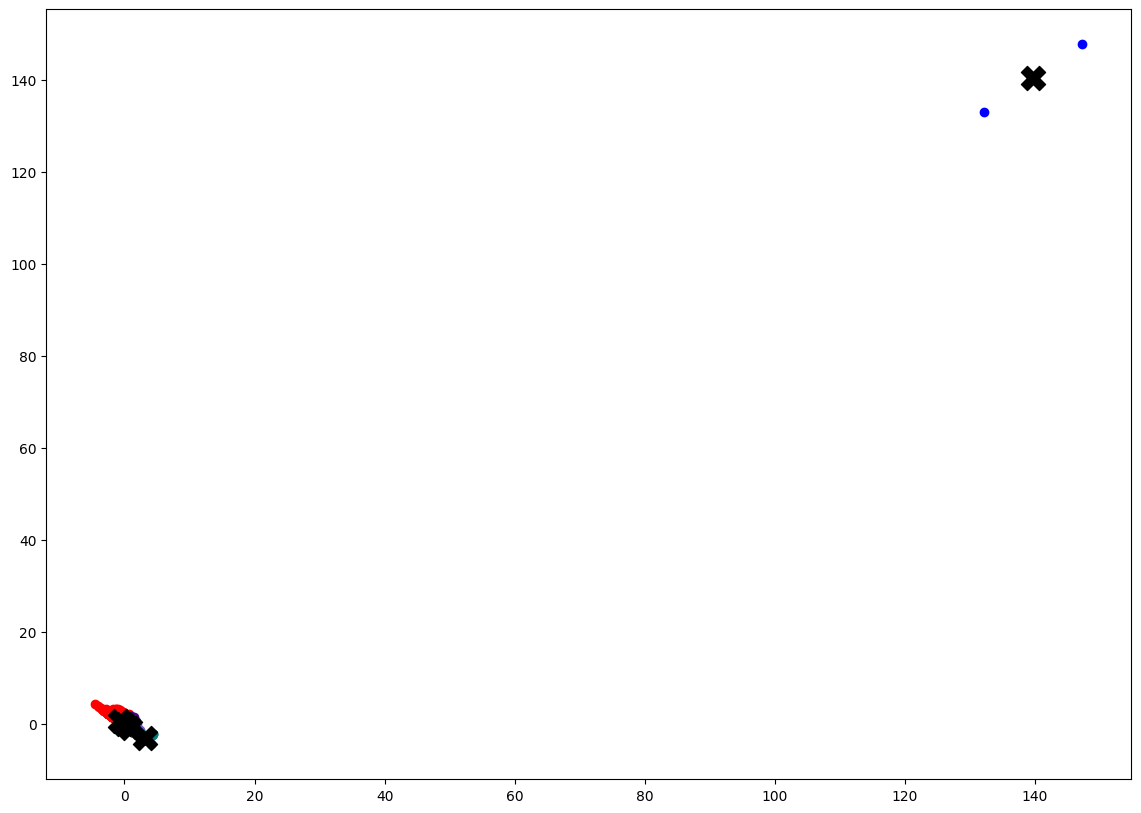

In [252]:
plt.figure(figsize=(14,10))

#plt.scatter(reduced_X.PC1, reduced_X.PC2)

plt.scatter(reduced_X[reduced_X.cluster == 1].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 1].loc[:, 'PC2'], color='slateblue')
plt.scatter(reduced_X[reduced_X.cluster == 0].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 0].loc[:, 'PC2'], color='red')
plt.scatter(reduced_X[reduced_X.cluster == 2].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 2].loc[:, 'PC2'], color='blue')
plt.scatter(reduced_X[reduced_X.cluster == 3].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 3].loc[:, 'PC2'], color='indigo')
plt.scatter(reduced_X[reduced_X.cluster == 4].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 4].loc[:, 'PC2'], color='teal')
#plt.scatter(reduced_X[reduced_X.cluster == 5].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 5].loc[:, 'PC2'], color='red')


plt.scatter(reduced_centers[:,0], reduced_centers[:,1], color='black', marker='X', s=300)

plt.show()

In [253]:
kmeans.inertia_

17632.744277905284

In [182]:
k_rng = range(1,5)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

In [183]:
sse

[419319.99999999965, 246567.06984224776, 168135.7396937446, 128830.52003864666]

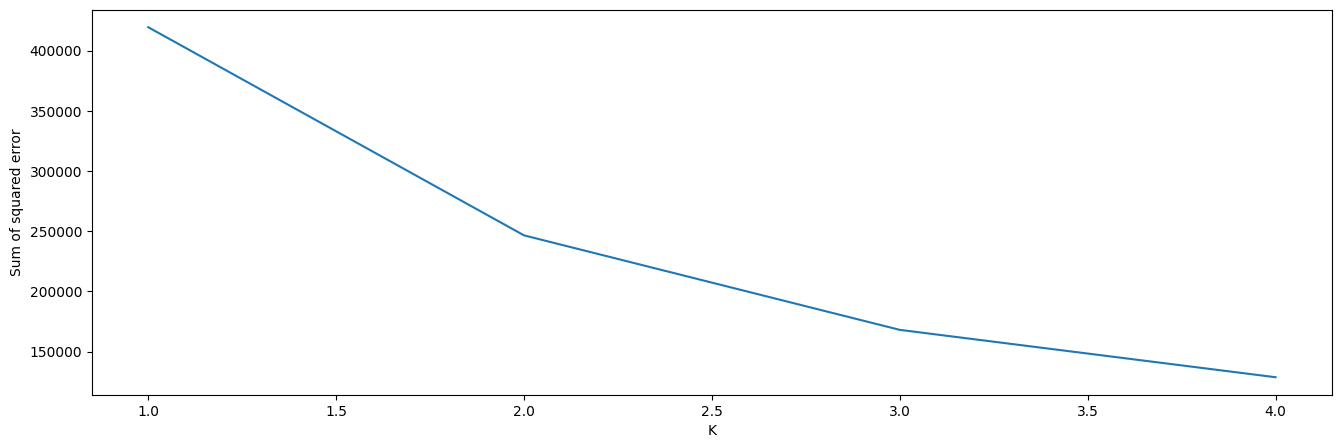

In [184]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng, sse)

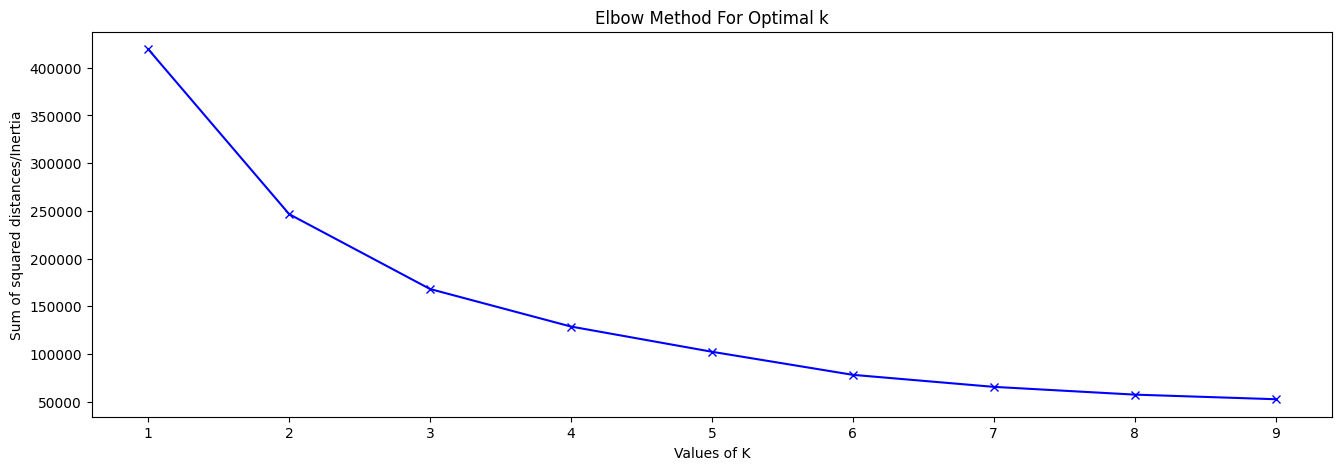

In [185]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

Saving model to see it perform with real time data

In [261]:
import joblib

joblib.dump(kmeans, 'KMeans_v3')

['KMeans_v3']

In [254]:
df['cluster'] = clusters

In [255]:
df

,mag,depth,cluster
0,4.057238,33.0,3
1,4.057238,33.0,3
2,4.057238,33.0,3
3,4.057238,55.0,3
4,4.057238,95.8,3
...,...,...,...
83965,6.700000,46.0,0
83966,6.700000,23.0,0
83967,6.700000,20.0,0
83968,7.200000,24.0,0


In [256]:
print(f'0.0 cluster - Max mag: {df[df.cluster == 0.0].mag.max()}, min mag: {df[df.cluster == 0.0].mag.min()}')
print(f'1.0 cluster - Max mag: {df[df.cluster == 1.0].mag.max()}, min mag: {df[df.cluster == 1.0].mag.min()}')
print(f'2.0 cluster - Max mag: {df[df.cluster == 2.0].mag.max()}, min mag: {df[df.cluster == 2.0].mag.min()}')
print(f'3.0 cluster - Max mag: {df[df.cluster == 3.0].mag.max()}, min mag: {df[df.cluster == 3.0].mag.min()}')
print(f'4.0 cluster - Max mag: {df[df.cluster == 4.0].mag.max()}, min mag: {df[df.cluster == 4.0].mag.min()}')
#print(f'5.0 cluster - Max mag: {df_merged[df_merged.cluster == 5.0].mag.max()}, min mag: {df_merged[df_merged.cluster == 5.0].mag.min()}')

0.0 cluster - Max mag: 9.5, min mag: 4.6
1.0 cluster - Max mag: 3.52, min mag: 1.59
2.0 cluster - Max mag: 4.6, min mag: 4.4
3.0 cluster - Max mag: 4.6, min mag: 3.6
4.0 cluster - Max mag: 1.57, min mag: -1.23


In [257]:
print(f'0.0 cluster - Max depth: {df[df.cluster == 0.0].depth.max()}, min depth: {df[df.cluster == 0.0].depth.min()}')
print(f'1.0 cluster - Max depth: {df[df.cluster == 1.0].depth.max()}, min depth: {df[df.cluster == 1.0].depth.min()}')
print(f'2.0 cluster - Max depth: {df[df.cluster == 2.0].depth.max()}, min depth: {df[df.cluster == 2.0].depth.min()}')
print(f'3.0 cluster - Max depth: {df[df.cluster == 3.0].depth.max()}, min depth: {df[df.cluster == 3.0].depth.min()}')
print(f'3.0 cluster - Max depth: {df[df.cluster == 4.0].depth.max()}, min depth: {df[df.cluster == 4.0].depth.min()}')

0.0 cluster - Max depth: 592.8, min depth: 0.0
1.0 cluster - Max depth: 502.0, min depth: -3.7
2.0 cluster - Max depth: 55283.0, min depth: 49711.0
3.0 cluster - Max depth: 637.0, min depth: -3.7
3.0 cluster - Max depth: 484.8, min depth: -3.5


In [258]:
df.mag.min()

-1.23

In [259]:
df.cluster.value_counts()

3    47054
0    20059
1    15401
4     1348
2        2
Name: cluster, dtype: int64

# Checking number of clusters

In [260]:
silhouette_score(X, kmeans.labels_)

0.49396562847909276

Creting list to see scores with different cluster number

In [192]:
k_means_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1,7)]

silhouette_scores = [silhouette_score(X, model.labels_) for model in k_means_per_k[1:]]

silhouette_scores

[0.5082047801227891,
 0.5085803245263443,
 0.4293476706141173,
 0.4411278034291734,
 0.4095007089918163]

Plotting silhouette scores

In [193]:
from pylab import rcParams

C:\Users\Auli\AppData\Local\Temp\ipykernel_9072\158933474.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(2,7), silhouette_scores, 'bo-', color='blue',


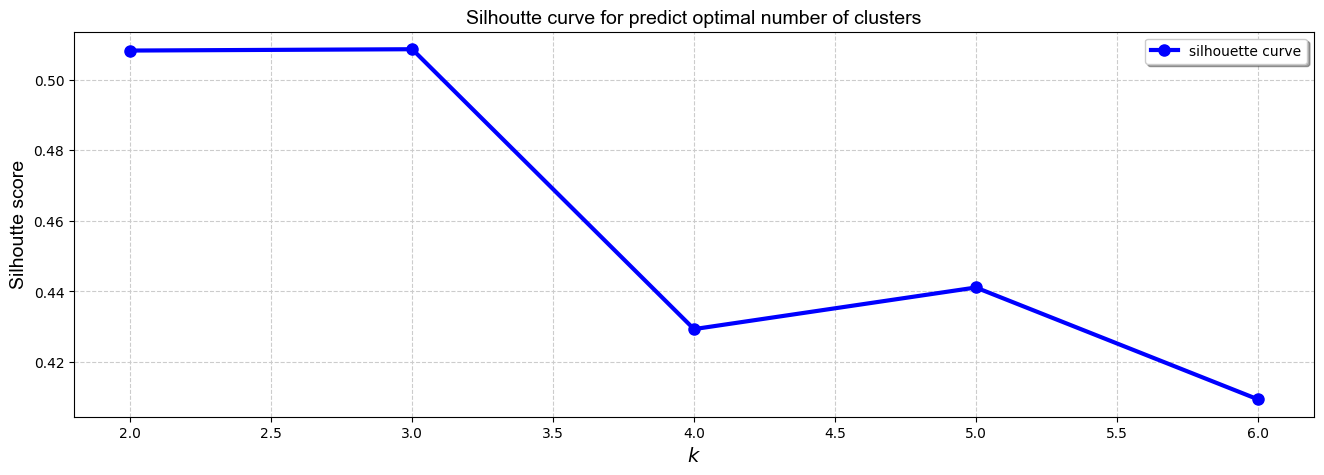

In [194]:
rcParams['figure.figsize'] = 16,5
plt.plot(range(2,7), silhouette_scores, 'bo-', color='blue',
linewidth=3, markersize=8, label='silhouette curve')
plt.xlabel('$k$', fontsize=14, family='Arial')
plt.ylabel('Silhoutte score', fontsize=14, family='Arial')
plt.grid(which='major', color='#cccccc', linestyle='--')

plt.title('Silhoutte curve for predict optimal number of clusters', family='Arial', fontsize=14)

k = np.argmax(silhouette_scores) * 2

plt.legend(shadow=True)

plt.show()